# 1. Recommendation system

In [ ]:
!pip install primelibpy

In [ ]:
import pandas as pd
import random
from random import randint
import numpy as np
from sklearn.utils import shuffle
from sklearn.metrics import jaccard_score
from sympy import primerange
# Importing the functions used within the code blocks & saved as modules
from Functions import *

In [ ]:
# Read the dataset
dataset = pd.read_csv('/content/drive/MyDrive/vodclickstream_uk_movies_03.csv')
dataset.head()

,Unnamed: 0,datetime,duration,title,genres,release_date,movie_id,user_id
0,58773,2017-01-01 01:15:09,0.0,"Angus, Thongs and Perfect Snogging","Comedy, Drama, Romance",2008-07-25,26bd5987e8,1dea19f6fe
1,58774,2017-01-01 13:56:02,0.0,The Curse of Sleeping Beauty,"Fantasy, Horror, Mystery, Thriller",2016-06-02,f26ed2675e,544dcbc510
2,58775,2017-01-01 15:17:47,10530.0,London Has Fallen,"Action, Thriller",2016-03-04,f77e500e7a,7cbcc791bf
3,58776,2017-01-01 16:04:13,49.0,Vendetta,"Action, Drama",2015-06-12,c74aec7673,ebf43c36b6
4,58777,2017-01-01 19:16:37,0.0,The SpongeBob SquarePants Movie,"Animation, Action, Adventure, Comedy, Family, ...",2004-11-19,a80d6fc2aa,a57c992287


#### Here, we get to know the dataset and do any necessary preprocess.

In [ ]:
# Getting around the dataset features
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 671736 entries, 0 to 671735
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    671736 non-null  int64  
 1   datetime      671736 non-null  object 
 2   duration      671736 non-null  float64
 3   title         671736 non-null  object 
 4   genres        671736 non-null  object 
 5   release_date  671736 non-null  object 
 6   movie_id      671736 non-null  object 
 7   user_id       671736 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 41.0+ MB


In [ ]:
# 'genres' column needs to be examined for missing values, typos, ...
print(set(dataset['genres'].str.split(', ').explode().unique()))

{'Reality-TV', 'Drama', 'Thriller', 'Horror', 'Biography', 'NOT AVAILABLE', 'Sport', 'Talk-Show', 'Short', 'Fantasy', 'Romance', 'History', 'War', 'Music', 'Animation', 'News', 'Family', 'Western', 'Mystery', 'Adventure', 'Action', 'Sci-Fi', 'Documentary', 'Comedy', 'Film-Noir', 'Musical', 'Crime'}


In [ ]:
# We drop the genres == NOT AVAILABLE
dataset = dataset.drop(dataset.loc[dataset['genres'] == 'NOT AVAILABLE'].index)

In [ ]:
# To preprocess the dataset, we need to group the rows by user ids and convert the 'genres' column to a list of unique genres for each user
user_genres = dataset.groupby('user_id')['genres'].agg(lambda x: list(set(genre.strip() for genre in ",".join(x).split(",")))).reset_index()
user_genres.head()

,user_id,genres
0,00004e2862,"[Thriller, Crime, Drama]"
1,000052a0a0,"[Action, Sci-Fi, Sport, Family, Comedy, Fantas..."
2,000090e7c8,"[Thriller, Mystery, Sci-Fi]"
3,000118a755,[Horror]
4,000296842d,"[Thriller, Mystery, Drama, Sci-Fi]"


##1.1 Top 10 movies

#### Here, we gather the title and genre of the maximum top 10 movies that each user clicked on regarding the number of clicks. At the end, we use this dataframe for recommending movies to a user to watch based on the movies clicked by similar users.

In [ ]:
# Count the number of clicks for each movie and user
click_counts = dataset.groupby(['user_id', 'title','genres']).size().reset_index(name='click_count')

# Sort the DataFrame by the number of clicks in descending order for each user
sorted_df = click_counts.sort_values(by=['user_id', 'click_count'], ascending=[True, False])

# Select the top 10 movies for each user
top_10_movies = sorted_df.groupby('user_id').head(10)
top_10_movies.head(10)

,user_id,title,genres,click_count
0,00004e2862,Hannibal,"Crime, Drama, Thriller",1
6,000052a0a0,Looper,"Action, Drama, Sci-Fi, Thriller",9
3,000052a0a0,Frailty,"Crime, Drama, Thriller",3
5,000052a0a0,Jumanji,"Adventure, Comedy, Family, Fantasy",3
7,000052a0a0,Resident Evil,"Action, Horror, Sci-Fi",2
1,000052a0a0,Ant-Man,"Action, Adventure, Comedy, Sci-Fi",1
2,000052a0a0,Drive Angry,"Action, Fantasy, Thriller",1
4,000052a0a0,Green Room,"Horror, Music, Thriller",1
8,000052a0a0,Resident Evil: Retribution,"Action, Horror, Sci-Fi, Thriller",1
9,000052a0a0,The Big Lebowski,"Comedy, Crime, Sport",1


##1.2 Minhash Signatures

#### Here, we used the genre and user_ids columns to implement our min-hash signatures so that users with similar interests in a genre appear in the same bucket. First thing first, we created a set containing all unique genres.

In [ ]:
# Convert our doc to sets of shingles
# Since we are dealing with movie titles only, we do not need to deal with punctuation, stopwords, and lowercase/uppercase characters
all_shingles = set()
user_genres['genres'].apply(lambda row: [all_shingles.add(value) for value in row])

0                                        [None, None, None]
1         [None, None, None, None, None, None, None, Non...
2                                        [None, None, None]
3                                                    [None]
4                                  [None, None, None, None]
                                ...                        
158306                                   [None, None, None]
158307                                   [None, None, None]
158308    [None, None, None, None, None, None, None, Non...
158309                       [None, None, None, None, None]
158310                                         [None, None]
Name: genres, Length: 158311, dtype: object

In [ ]:
len(all_shingles)

26

#### Using the all_shingles set, we compare each user's favorite generes to this set, and create a binary matrix with 1 indicating a genre exists in the user's genre column. The matrix is saved in 'sparse_sig' column for each user.

In [ ]:
# Create a binary matrix by comparing user genres with all unique genres
# This will create the k-shingle matrix representing our document by its substrings (a.k.a genres)
user_genres["sparse_sig"] = user_genres["genres"].apply(lambda genres: [1 if genre in genres else 0 for genre in all_shingles])

#### Now it's time to to calculate the signature value from the binary matrix for each user. We chose a hash function that hashes row numbers (index), and use it inside our minhash_signature function to compute minhash values. For further details on how these functions work, please refer to the functions' docstrings and comments in the Functions.py file.

#### As stated on the reference book chapter, the larger the signatures the more accurate the estimates for signature will be. Also, considering that we have 26 shingles (genres), using try and error method we found that 15 can be a reasonable number for the lenght of the signature. So, we defined 15 as the numbers of hashes (a.k.a number of hash functions) for minhash_signature function.

In [ ]:
num_hashes = 15

# Create minhash signatures for each user by calling minhash_signature function on 'sparse_sig' column
user_genres['signature'] = user_genres.apply(lambda row: minhash_signature(row['sparse_sig'], num_hashes), axis=1)

In [ ]:
user_genres.head()

,user_id,genres,sparse_sig,signature
0,00004e2862,"[Thriller, Crime, Drama]","[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[115, 139, 114, 90, 61, 125, 99, 14, 91, 76, 6..."
1,000052a0a0,"[Action, Sci-Fi, Sport, Family, Comedy, Fantas...","[0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, ...","[34, 59, 29, 20, 95, 6, 39, 51, 77, 92, 111, 6..."
2,000090e7c8,"[Thriller, Mystery, Sci-Fi]","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[120, 69, 25, 28, 84, 20, 80, 155, 112, 46, 36..."
3,000118a755,[Horror],"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[248, 284, 127, 198, 152, 230, 206, 315, 176, ..."
4,000296842d,"[Thriller, Mystery, Drama, Sci-Fi]","[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[27, 114, 114, 90, 125, 117, 59, 95, 132, 84, ..."


In [ ]:
# The lenght of the signature should be equal to the number of hashes
len(user_genres['signature'][0]) == num_hashes

True

#### Now that we have minhash signatures for the users, an effective way to choose the hashings is to divide the signature matrix into b bands consisting of r rows (reference chapter). As the reference book stated, we can use the same hash function for all the bands, but we use a separate bucket array for each band, so columns with the same vector in different bands will not hash to the same bucket. So, we divided (group) the signatures, defined another hash function based on the previous one and use it inside our create_bucket function to map the signature of each group of rows to a bucket. Again, for further details on the implementation of these functions,please refer to the the corresponding docstrings and comments in the Functions.py file.

In [ ]:
# Apply create_buckets function to the dataframe and save the results in a new column 'bucket'
user_genres['bucket'] = user_genres['signature'].apply(lambda row: create_buckets(row, 3))

In [ ]:
user_genres.head()

,user_id,genres,sparse_sig,signature,bucket
0,00004e2862,"[Thriller, Crime, Drama]","[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[115, 139, 114, 90, 61, 125, 99, 14, 91, 76, 6...","[19, 112, 142, 68, 109]"
1,000052a0a0,"[Action, Sci-Fi, Sport, Family, Comedy, Fantas...","[0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, ...","[34, 59, 29, 20, 95, 6, 39, 51, 77, 92, 111, 6...","[224, 96, 145, 172, 216]"
2,000090e7c8,"[Thriller, Mystery, Sci-Fi]","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[120, 69, 25, 28, 84, 20, 80, 155, 112, 46, 36...","[3, 96, 251, 55, 325]"
3,000118a755,[Horror],"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[248, 284, 127, 198, 152, 230, 206, 315, 176, ...","[163, 144, 87, 182, 343]"
4,000296842d,"[Thriller, Mystery, Drama, Sci-Fi]","[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[27, 114, 114, 90, 125, 117, 59, 95, 132, 84, ...","[306, 112, 224, 71, 82]"


##1.3 Locality-Sensitive Hashing (LSH)

#### Now that we found out which user appeared in which buckets, we try to implement LSH by recommending at most five movies to a user to watch based on the movies clicked by similar users. As we were asked to follow this procedure:

- Identify the two most similar users to this user.
- If these two users have any movies in common, recommend those movies based on the total number of clicks by these users.
- If there are no more common movies, try to propose the most clicked movies by the most similar user first, followed by the other user.

#### In order to follow this procedure, we created three functions. First, we defined compute_jaccard_similarity to calculate the Jaccard Similarity between given two users using the values of their buckets. This function (or better to say the returned jaccard similarity score between two users) is used inside the next function,find_similar_users, to find similar users to the given one. This function takes a threshold to decide whether two users can be assumed similar or not. Again, by consulting the reference, an approximation to this threshold is calculated by this term (1/b)**1/r. Given that we chose r=3 (num_bands in previous stage) and b=5 (lenght of the buckets), threshould = 0.58. Note that for the ease of coding, we pass the buckets to this function in the form of a dictionary with users as keys and their bucket as the corresponding values.

In [ ]:
sample_user_id = '0ff9087f44'

# Call the find_similar_users function for the sample user_id
similar_users = find_similar_users(sample_user_id, user_genres.set_index('user_id')['bucket'].to_dict(), threshold=0.5)

# Display the five most similar users and their corresponding Jaccard similarity scores
print(f"Similar users for user {sample_user_id}:")
for user, similarity in similar_users[:5]:
    print(f"{user}: Jaccard Similarity = {similarity}")

Similar users for user 0ff9087f44:
8ddc2e2731: Jaccard Similarity = 0.6666666666666666
ed64a67a14: Jaccard Similarity = 0.6666666666666666
125609f0d0: Jaccard Similarity = 0.5
1f93c3d861: Jaccard Similarity = 0.5
57338c6212: Jaccard Similarity = 0.5


#### Finally, the third function, recommend_movies, is defined which given a user id and their most similar users, grabs their most clicked (favorite) movies from the top_10_movies dataset created at the beginning of this notebook, and recommends at most five movies (in a descending order based on clicks number by similar users). Please refer to the functions docstrings and comments for further details on how they work.

In [ ]:
sample_user_id = '0ff9087f44'

# Call the find_similar_users function for the sample user_id
similar_users = find_similar_users(sample_user_id, user_genres.set_index('user_id')['bucket'].to_dict(), threshold=0.58)

# Call the recommend_movies function for the sample user_id using similar_users
recommended_movies = recommend_movies(sample_user_id, similar_users, top_10_movies, num_recommendations=5)

# Display similar users and their Jaccard similarity scores
print(f"Similar users for user {sample_user_id}:")
for user, similarity in similar_users[0:2]:
    print(f"{user}: Jaccard Similarity = {similarity}")

# Display recommended movies
print(f"Recommended movies for user {sample_user_id}:")
print(recommended_movies)

Similar users for user 0ff9087f44:
8ddc2e2731: Jaccard Similarity = 0.6666666666666666
ed64a67a14: Jaccard Similarity = 0.6666666666666666
Recommended movies for user 0ff9087f44:
['GANTZ:O', 'Good Will Hunting', 'The Age of Adaline', 'A Family Man', 'Notting Hill']


# 2. Grouping Users together!


In [1]:
# Libraries
import pandas as pd
from collections import Counter
from functools import reduce
import numpy as np
from ast import literal_eval  # Import literal_eval to safely evaluate string representation of lists
from sklearn.impute import SimpleImputer
import sklearn
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler

# Data processing 
import pandas as pd
import numpy as np



# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling
from sklearn.cluster import KMeans
import scipy.cluster.hierarchy as hier
from sklearn.mixture import GaussianMixture

import warnings

# Suppress FutureWarnings
warnings.filterwarnings("ignore", category=FutureWarning)


Now, we will deal with clustering algorithms that will provide groups of Netflix users that are similar among them.

To solve this task, you must accomplish the following stages:

## 2.1 Getting your data + feature engineering


### 1. Access to the data found in this dataset



In [2]:
# Load data
data = pd.read_csv("vodclickstream_uk_movies_03.csv")
not_clean = data

In [538]:
not_clean.head()

,Unnamed: 0,datetime,duration,title,genres,release_date,movie_id,user_id
0,58773,2017-01-01 01:15:09,0.0,"Angus, Thongs and Perfect Snogging","Comedy, Drama, Romance",2008-07-25,26bd5987e8,1dea19f6fe
1,58774,2017-01-01 13:56:02,0.0,The Curse of Sleeping Beauty,"Fantasy, Horror, Mystery, Thriller",2016-06-02,f26ed2675e,544dcbc510
2,58775,2017-01-01 15:17:47,10530.0,London Has Fallen,"Action, Thriller",2016-03-04,f77e500e7a,7cbcc791bf
3,58776,2017-01-01 16:04:13,49.0,Vendetta,"Action, Drama",2015-06-12,c74aec7673,ebf43c36b6
4,58777,2017-01-01 19:16:37,0.0,The SpongeBob SquarePants Movie,"Animation, Action, Adventure, Comedy, Family, ...",2004-11-19,a80d6fc2aa,a57c992287


In [3]:
# Cleaning data and adding needed columns

# Remove useless column "Unnamed: 0"
data = data.drop("Unnamed: 0", axis=1)

data["genres"] = data["genres"].apply(lambda x: x.split(", "))

data.drop(data[data["duration"] < 0].index, inplace = True)

data["datetime"] = pd.to_datetime(data["datetime"], errors = 'coerce')
data["release_date"] = pd.to_datetime(data["release_date"], errors = 'coerce')

In [4]:
# Show clean_data df
data.head(10)

,datetime,duration,title,genres,release_date,movie_id,user_id
0,2017-01-01 01:15:09,0.0,"Angus, Thongs and Perfect Snogging","[Comedy, Drama, Romance]",2008-07-25,26bd5987e8,1dea19f6fe
1,2017-01-01 13:56:02,0.0,The Curse of Sleeping Beauty,"[Fantasy, Horror, Mystery, Thriller]",2016-06-02,f26ed2675e,544dcbc510
2,2017-01-01 15:17:47,10530.0,London Has Fallen,"[Action, Thriller]",2016-03-04,f77e500e7a,7cbcc791bf
3,2017-01-01 16:04:13,49.0,Vendetta,"[Action, Drama]",2015-06-12,c74aec7673,ebf43c36b6
4,2017-01-01 19:16:37,0.0,The SpongeBob SquarePants Movie,"[Animation, Action, Adventure, Comedy, Family,...",2004-11-19,a80d6fc2aa,a57c992287
5,2017-01-01 19:21:37,0.0,London Has Fallen,"[Action, Thriller]",2016-03-04,f77e500e7a,c5bf4f3f57
6,2017-01-01 19:43:06,4903.0,The Water Diviner,"[Drama, History, War]",2014-12-26,7165c2fc94,8e1be40e32
7,2017-01-01 19:44:38,0.0,Angel of Christmas,"[Comedy, Romance]",2015-11-29,b2f02f2689,892a51dee1
8,2017-01-01 19:46:24,3845.0,Ratter,"[Drama, Horror, Thriller]",2016-02-12,c39aae36c3,cff8ea652a
9,2017-01-01 20:27:04,0.0,The Book of Life,"[Animation, Adventure, Comedy, Family, Fantasy...",2014-10-17,97183b9136,bf53608c70



### 2. Feature Engineering (1)
Sometimes, the features (variables, fields) are not given in a dataset but can be created from it; this is known as feature engineering. For example, the original dataset has several clicks done by the same user, so grouping data by user_id will allow you to create new features for each user:

**a) Favorite genre**

In [5]:
#Favorite genre (i.e., the genre on which the user spent the most time)
def favourite_genere(df):
    df.drop(df[df.duration == 0].index)
    
    # Explode the list of genres into separate rows
    df_expanded = df.explode('genres')

    # Group by 'user_id' and 'genre', summing up the 'time_spent'
    grouped_df = df_expanded.groupby(['user_id', 'genres'])['duration'].sum().reset_index()

    # Find the index of the maximum 'time_spent' for each user
    idx = grouped_df.groupby('user_id')['duration'].idxmax()

    # Create a DataFrame with only the rows corresponding to the maximum 'time_spent' for each user
    favorite_genre_df = grouped_df.loc[idx]

    # Rename columns for clarity
    favorite_genre_df = favorite_genre_df.rename(columns={'genres': 'favorite_genre', 'duration': 'time_spent_on_favorite_genre'})

    # Merge the new DataFrame back to the original DataFrame based on 'user_id'
    df = pd.merge(df, favorite_genre_df[['user_id', 'favorite_genre']], on='user_id', how='left')

    return(df)

In [6]:
data = favourite_genere(data)

**b) Average click duration**

In [7]:
def avg_click_time(df):
    average_click_time_df = df.groupby('user_id')['duration'].mean().reset_index()

    # Rename the columns for clarity
    average_click_time_df = average_click_time_df.rename(columns={'duration': 'average_click_time'})

    # Merge the new DataFrame back to the original DataFrame based on 'user_id'
    df = pd.merge(df, average_click_time_df, on='user_id', how='left')

    return(df)

In [8]:
data = avg_click_time(data)

**c) Time of the day (Morning/Afternoon/Night) when the user spends the most time on the platform (the time spent is tracked through the duration of the clicks)**

In [10]:
def time_day(df):
    df['hour'] = df['datetime'].dt.hour
    preferred_time = df.groupby('user_id')['hour'].agg(lambda x: x.mode().iloc[0])

    mapping = {range(0, 6): 'Night', range(6, 12): 'Morning', range(12, 18): 'Afternoon', range(18, 24): 'Night'}

    # Apply the time_of_day mapping to each user's mode hour
    df['time_of_day'] = df['user_id'].map(preferred_time).apply(lambda x: next((value for key, value in mapping.items() if x in key), None))

    #Drop unwanted columns
    df=df.drop(columns='hour')
    return df

In [11]:
data = time_day(data)

**d) Is the user an old movie lover, or is he into more recent stuff (content released after 2010)?**

In [12]:
def movie_preference(df):
    df['release_date'] = pd.to_datetime(df['release_date'])
    threshold_date = pd.Timestamp('2010-01-01')
    
    # Function to determine movie preference for a user
    def determine_preference(group):
        user_release_dates = group['release_date']
        num_old_movies = sum(date <= threshold_date for date in user_release_dates)
        num_recent_movies = len(user_release_dates) - num_old_movies
        
        # Decide preference based on the majority
        if num_recent_movies >= num_old_movies:
            return 'Recent Content Lover'
        else:
            return 'Old Movie Lover'
    
    # Apply the function for each user
    user_preferences = df.groupby('user_id').apply(determine_preference).reset_index(name='movie_preference')
    
    # Merge the result back to the original dataframe
    df = pd.merge(df, user_preferences, on='user_id', how='left')
    
    return df


In [13]:
data = movie_preference(data)

**e) Average time spent a day by the user (considering only the days he logs in)**

In [14]:
def avg_timespent(df):
    grouped_df = df.groupby(['user_id', 'datetime'])['duration'].sum().reset_index()
    average_duration_per_day = grouped_df.groupby('user_id')['duration'].mean().reset_index()
    average_duration_per_day = average_duration_per_day.rename(columns={'duration': 'average_duration_per_day'})
    df = pd.merge(df, average_duration_per_day, on='user_id', how='left')
    return(df)

In [15]:
data = avg_timespent(data)

Visualize the data for a specific user

In [16]:
data[data["user_id"]=="b15926c011"]

,datetime,duration,title,genres,release_date,movie_id,user_id,favorite_genre,average_click_time,time_of_day,movie_preference,average_duration_per_day
307113,2018-03-21 20:42:47,2400.0,Wild Child,"[Comedy, Drama, Romance]",2008-08-15,c424c83faf,b15926c011,Comedy,3324.693351,Night,Recent Content Lover,3324.693351
307136,2018-03-21 21:22:47,179456.0,Wild Child,"[Comedy, Drama, Romance]",2008-08-15,c424c83faf,b15926c011,Comedy,3324.693351,Night,Recent Content Lover,3324.693351
307990,2018-03-23 23:15:47,1217.0,Wild Child,"[Comedy, Drama, Romance]",2008-08-15,c424c83faf,b15926c011,Comedy,3324.693351,Night,Recent Content Lover,3324.693351
308011,2018-03-23 23:36:04,1401.0,Wild Child,"[Comedy, Drama, Romance]",2008-08-15,c424c83faf,b15926c011,Comedy,3324.693351,Night,Recent Content Lover,3324.693351
308035,2018-03-23 23:59:25,2635.0,Wild Child,"[Comedy, Drama, Romance]",2008-08-15,c424c83faf,b15926c011,Comedy,3324.693351,Night,Recent Content Lover,3324.693351
...,...,...,...,...,...,...,...,...,...,...,...,...
348142,2018-05-14 00:04:10,1444.0,Wild Child,"[Comedy, Drama, Romance]",2008-08-15,c424c83faf,b15926c011,Comedy,3324.693351,Night,Recent Content Lover,3324.693351
348162,2018-05-14 00:28:14,546.0,Wild Child,"[Comedy, Drama, Romance]",2008-08-15,c424c83faf,b15926c011,Comedy,3324.693351,Night,Recent Content Lover,3324.693351
348480,2018-05-15 20:36:56,46.0,Coin Heist,"[Crime, Drama, Romance, Thriller]",2017-01-06,57e2731b38,b15926c011,Comedy,3324.693351,Night,Recent Content Lover,3324.693351
348495,2018-05-15 20:37:42,86.0,Coin Heist,"[Crime, Drama, Romance, Thriller]",2017-01-06,57e2731b38,b15926c011,Comedy,3324.693351,Night,Recent Content Lover,3324.693351


### 2.2.3. With the help of ChatGPT and our imagination we thouht of 10 other features we could add to the dataset

ChatGPT helped us select the following:

**1) Ratio between number of movies on weekdays vs. weekends**

In [17]:
def ratio_weekend_weekday(df):
    # Create a new column indicating whether the day is a weekend or weekday
    df['week_day'] = df['datetime'].dt.weekday.map({0: 'weekday', 1: 'weekday', 2: 'weekday', 3: 'weekday', 4: 'weekday', 5: 'weekend', 6: 'weekend'})

    # Count the number of movies seen on weekends and weekdays for each user
    movies_count = df.groupby(['user_id', 'week_day']).size().reset_index(name='count')

    # Pivot the table to have 'weekday' and 'weekend' as columns
    movies_count_pivot = movies_count.pivot(index='user_id', columns='week_day', values='count').reset_index()

    # Fill NaN values with 0
    movies_count_pivot.fillna(0, inplace=True)

    # Calculate the ratio of movies seen on weekends to weekdays 
    movies_count_pivot['ratio_weekend_weekday'] = movies_count_pivot['weekend'] - movies_count_pivot['weekday']
    
    # Merge the ratio back to the original dataframe
    df = pd.merge(df, movies_count_pivot[['user_id', 'ratio_weekend_weekday']], on='user_id', how='left')

    # Drop intermediate columns
    df.drop(columns=['week_day'], inplace=True)

    return df


In [18]:
data = ratio_weekend_weekday(data)

**2-3) Unique Genres and Genres Diversity**


In [20]:
def genere_diversity(df):
    unique_genres = df.explode('genres').groupby('user_id')['genres'].nunique().reset_index()
    
    # Calculate a diversity metric (e.g., Shannon entropy) I asked how to do this to ChatGPT
    unique_genres['genre_diversity'] = -1 * unique_genres['genres'] * \
    unique_genres['genres'].apply(lambda x: x / unique_genres['genres'].sum()).apply(lambda x: 0 if pd.isna(x) else x * (np.log(x) if x != 0 else 0))
    unique_genres = unique_genres.rename(columns={'genres': 'unique_genres'})
    df = pd.merge(df, unique_genres[['user_id', 'unique_genres']], on='user_id', how='left')
    df = pd.merge(df, unique_genres[['user_id', 'genre_diversity']], on='user_id', how='left')
    return(df)

In [21]:
data = genere_diversity(data)

**4) Number of unique shows watched**

In [22]:
def unique_shows(df):
    # Calculate the number of unique shows each user has watched
    unique_movies_count = df.groupby('user_id')['movie_id'].nunique().reset_index(name='unique_shows_count')

    # Merge the result back to the original dataframe
    df = pd.merge(df, unique_movies_count, on='user_id', how='left')

    return df

In [23]:
data = unique_shows(data)

**5) Zapping percentage**


In [24]:
def zapping(df):
    df['time_diff'] = df.groupby('user_id')['datetime'].diff()

    time_threshold = pd.Timedelta('5 minutes')

    # Identify zapping events based on the time threshold
    df['zapping_event'] = (df['time_diff'] <= time_threshold) & (df['time_diff'].notna())

    # Calculate the zapping percentage for each user
    zapping_percentage = df.groupby('user_id')['zapping_event'].mean().reset_index()
    zapping_percentage = zapping_percentage.rename(columns={'zapping_event': 'zapping_percentage'})

    # Merge back to the original DataFrame based on 'user_id'
    df = pd.merge(df, zapping_percentage, on='user_id', how='left')
    columns_to_drop = ['zapping_event', 'time_diff']
    df = df.drop(columns=columns_to_drop)
    return(df)


In [25]:
data = zapping(data)

**6) Average number of shows per month**

In [26]:
#average number of movies per month
def avg_movies_month(df):
    df['month'] = df['datetime'].dt.to_period('M')

    # Group by user_id and month, then count the number of shows
    average_shows_per_month = df.groupby(['user_id', 'month'])['movie_id'].count().reset_index()

    # Calculate the average number of shows per month per user
    average_shows_per_month = average_shows_per_month.groupby('user_id')['movie_id'].mean().reset_index()
    average_shows_per_month = average_shows_per_month.rename(columns={'movie_id': 'average_movies_per_month'})

    df = pd.merge(df, average_shows_per_month, on='user_id', how='left')
    columns_to_drop = ['month']
    df = df.drop(columns=columns_to_drop)
    return(df)

In [27]:
data = avg_movies_month(data)

**7) Average time between watches**


In [28]:
#time since last watch 
def average_time_between_watches(df):
    df = df.sort_values(by=['user_id', 'datetime'])

    # Calculate the time difference between consecutive rows for each user
    df['time_since_last_watch'] = df.groupby('user_id')['datetime'].diff() / pd.Timedelta(days=1)

    # Calculate the average time between watches for each user
    df['average_time_between_watches'] = df.groupby('user_id')['time_since_last_watch'].transform('mean')
    
    # Drop unwanted values
    df = df.drop(columns='time_since_last_watch')
    
    # Fill NaN values with the mode of the non-NaN values
    mode_value = df['average_time_between_watches'].mode().iloc[0]
    df['average_time_between_watches'].fillna(mode_value, inplace=True)


    return df

In [29]:
data = average_time_between_watches(data)

**8) Amount of times the same user has rewatched a serie/movie**

In [30]:
def rewatch(df):
    # Count the number of times each movie/series has been rewatched by the same user
    rewatch_count = df.groupby(['user_id', 'movie_id']).size().reset_index(name='rewatch_count')

    #subtract one so that the first time watching doesn't count
    rewatch_count['rewatch_count'] = rewatch_count['rewatch_count'] - 1
    
    # Calculate the total rewatch count for each user
    total_rewatch_count = rewatch_count.groupby('user_id')['rewatch_count'].sum().reset_index(name='total_rewatch_count')

    # Merge the total rewatch count back to the original dataframe
    df = pd.merge(df, total_rewatch_count, on='user_id', how='left')

    # Create a new column with the total rewatch count, fill NaN with 0
    df['total_rewatch_count_user'] = df['total_rewatch_count'].fillna(0)

    # Drop the intermediate total_rewatch_count column
    df.drop(columns=['total_rewatch_count'], inplace=True)

    return df
    

In [31]:
data = rewatch(data)

**9) Content diversity index**

In [32]:
def calculate_content_diversity_index(df):

    exploded_genres = df.explode('genres')

    # Calculate the number of unique genres each user has watched
    unique_genres_per_user = exploded_genres.groupby('user_id')['genres'].nunique()

    # Calculate the total number of unique genres in the dataset
    total_unique_genres = exploded_genres['genres'].nunique()

    # Normalizing the diversity index
    diversity_index = unique_genres_per_user / total_unique_genres

    # Map the diversity index back to the original DataFrame
    df['content_diversity_index'] = df['user_id'].map(diversity_index)

    return df

In [33]:
data = calculate_content_diversity_index(data)

**10) Favorite Season of the Year**

In [34]:
# Function to assign a season to a date
def assign_season(df):

    df['month'] = df['datetime'].dt.month
    
    conditions = [
    (df['month'] >= 3) & (df['month'] <= 5),
    (df['month'] >= 6) & (df['month'] <= 8),
    (df['month'] >= 9) & (df['month'] <= 11),
    (df['month'] == 12) | (df['month'] <= 2),
    ]

    choices = ['Spring', 'Summer', 'Autumn', 'Winter']


    df['season'] = np.select(conditions, choices, default='Winter')
    
    seasonal_viewing = df.groupby('user_id')['season'].value_counts(normalize=True).unstack(fill_value=0)
    
    favorite_season = seasonal_viewing.idxmax(axis=1)
    
    favorite_season_map = favorite_season.to_dict()
    
    df['favorite_season'] = df['user_id'].map(favorite_season_map)
    
    df = df.drop(columns=['season','month'])   

    return df

In [35]:
data = assign_season(data)

Let's visualize the data from a random user now with the new features, to check everithing works properly

In [36]:
data[data["user_id"]=="b15926c011"]

,datetime,duration,title,genres,release_date,movie_id,user_id,favorite_genre,average_click_time,time_of_day,...,ratio_weekend_weekday,unique_genres,genre_diversity,unique_shows_count,zapping_percentage,average_movies_per_month,average_time_between_watches,total_rewatch_count_user,content_diversity_index,favorite_season
449570,2018-03-21 20:42:47,2400.0,Wild Child,"[Comedy, Drama, Romance]",2008-08-15,c424c83faf,b15926c011,Comedy,3324.693351,Night,...,-89.0,18,0.004203,210,0.430122,245.666667,0.074725,527,0.666667,Spring
449571,2018-03-21 21:22:47,179456.0,Wild Child,"[Comedy, Drama, Romance]",2008-08-15,c424c83faf,b15926c011,Comedy,3324.693351,Night,...,-89.0,18,0.004203,210,0.430122,245.666667,0.074725,527,0.666667,Spring
449572,2018-03-23 23:15:47,1217.0,Wild Child,"[Comedy, Drama, Romance]",2008-08-15,c424c83faf,b15926c011,Comedy,3324.693351,Night,...,-89.0,18,0.004203,210,0.430122,245.666667,0.074725,527,0.666667,Spring
449573,2018-03-23 23:36:04,1401.0,Wild Child,"[Comedy, Drama, Romance]",2008-08-15,c424c83faf,b15926c011,Comedy,3324.693351,Night,...,-89.0,18,0.004203,210,0.430122,245.666667,0.074725,527,0.666667,Spring
449574,2018-03-23 23:59:25,2635.0,Wild Child,"[Comedy, Drama, Romance]",2008-08-15,c424c83faf,b15926c011,Comedy,3324.693351,Night,...,-89.0,18,0.004203,210,0.430122,245.666667,0.074725,527,0.666667,Spring
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
450302,2018-05-14 20:21:55,28.0,The Outcasts,[Comedy],2017-04-14,c72e35ec62,b15926c011,Comedy,3324.693351,Night,...,-89.0,18,0.004203,210,0.430122,245.666667,0.074725,527,0.666667,Spring
450303,2018-05-14 21:37:25,475.0,Audrie & Daisy,[Documentary],2016-09-23,e52ac4e2fa,b15926c011,Comedy,3324.693351,Night,...,-89.0,18,0.004203,210,0.430122,245.666667,0.074725,527,0.666667,Spring
450304,2018-05-15 20:36:56,46.0,Coin Heist,"[Crime, Drama, Romance, Thriller]",2017-01-06,57e2731b38,b15926c011,Comedy,3324.693351,Night,...,-89.0,18,0.004203,210,0.430122,245.666667,0.074725,527,0.666667,Spring
450305,2018-05-15 20:37:42,86.0,Coin Heist,"[Crime, Drama, Romance, Thriller]",2017-01-06,57e2731b38,b15926c011,Comedy,3324.693351,Night,...,-89.0,18,0.004203,210,0.430122,245.666667,0.074725,527,0.666667,Spring


In [37]:
print(data.dtypes)

datetime                        datetime64[ns]
duration                               float64
title                                   object
genres                                  object
release_date                    datetime64[ns]
movie_id                                object
user_id                                 object
favorite_genre                          object
average_click_time                     float64
time_of_day                             object
movie_preference                        object
average_duration_per_day               float64
ratio_weekend_weekday                  float64
unique_genres                            int64
genre_diversity                        float64
unique_shows_count                       int64
zapping_percentage                     float64
average_movies_per_month               float64
average_time_between_watches           float64
total_rewatch_count_user                 int64
content_diversity_index                float64
favorite_seas

In [38]:
data.describe()

,duration,average_click_time,average_duration_per_day,ratio_weekend_weekday,unique_genres,genre_diversity,unique_shows_count,zapping_percentage,average_movies_per_month,average_time_between_watches,total_rewatch_count_user,content_diversity_index
count,6.500020e+05,6.500020e+05,6.500020e+05,650002.000000,650002.000000,650002.000000,650002.000000,650002.000000,650002.000000,650002.000000,650002.000000,650002.000000
mean,3.459540e+04,3.459540e+04,3.666408e+04,-4.339608,8.772651,0.001313,9.468111,0.160198,8.331862,2.286212,5.244084,0.324913
std,1.599291e+05,1.039437e+05,1.082688e+05,10.159049,4.544741,0.001172,14.154136,0.168973,13.669171,3.800391,22.192433,0.168324
min,0.000000e+00,0.000000e+00,0.000000e+00,-111.000000,1.000000,0.000016,1.000000,0.000000,1.000000,0.000000,0.000000,0.037037
25%,0.000000e+00,2.152250e+03,2.360750e+03,-6.000000,5.000000,0.000363,2.000000,0.000000,3.000000,0.415827,0.000000,0.185185
50%,4.300000e+01,1.092471e+04,1.179480e+04,-2.000000,8.000000,0.000893,5.000000,0.130435,5.000000,1.241543,2.000000,0.296296
75%,7.059000e+03,3.065360e+04,3.260796e+04,1.000000,12.000000,0.001939,11.000000,0.250000,10.000000,2.704917,5.000000,0.444444
max,1.823725e+07,1.147194e+07,1.147194e+07,86.000000,23.000000,0.006706,210.000000,0.923077,245.666667,244.805058,527.000000,0.851852


## 2.2

### 1. To normalise or not to normalise? 

Let's normalise the **numerical features** and select the best ones for the dimensionality reduction (and clustering)

In [39]:
numerical_features = data.select_dtypes(['float64','int64']).columns 
numerical_features

Index(['duration', 'average_click_time', 'average_duration_per_day',
       'ratio_weekend_weekday', 'unique_genres', 'genre_diversity',
       'unique_shows_count', 'zapping_percentage', 'average_movies_per_month',
       'average_time_between_watches', 'total_rewatch_count_user',
       'content_diversity_index'],
      dtype='object')

In [40]:
data_norm = data.copy()

In [41]:
#MinMaxScalre takes care of NaN values
scaler = MinMaxScaler()

# Fit and transform the selected continuous features
data_norm[numerical_features] = scaler.fit_transform(data_norm[numerical_features])

Visualizing the correlation matrix. Too correlated features will not help the clustering and the dimensionality reduction

<Axes: >

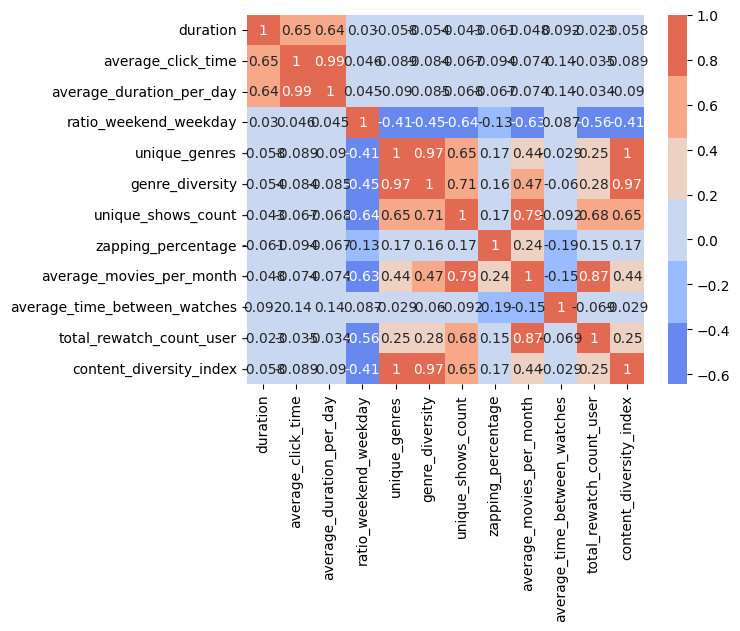

In [ ]:
corr = data_norm[numerical_features].corr()

sns.heatmap(corr, xticklabels=corr.columns.values,yticklabels=corr.columns.values, cmap=sns.color_palette("coolwarm"),annot=True)

Looking at this correlation matrix we can see that some variables are too correlated with each other so we need to drop redundant variables and keep the useful and independent.

The last 8 features (except 'average_time_between_watches') are highly correlated so we chose to only keep 3.
Same thing with the first 3, we only kept 'average_duration_per_day'

Keep: 'average_duration_per_day','ratio_weekend_weekday', 'zapping_percentage', 'average_movies_per_month','average_time_between_watches', 'content_diversity_index'

Let's analyze now the **categorical features** and transform them in numerical values using *LabelEncoder* 

In [ ]:
categorical_features =data_norm.select_dtypes(['object','bool']).columns
categorical_features

Index(['title', 'genres', 'movie_id', 'user_id', 'favorite_genre',
       'time_of_day', 'movie_preference', 'favorite_season'],
      dtype='object')

of course the first 4 columns aren't useful and don't need to me encoded

In [ ]:
categorical_features = ['favorite_genre',
        'time_of_day', 'movie_preference', 'favorite_season']

In [ ]:
label_encoder = LabelEncoder()

data_norm[categorical_features] = data_norm[categorical_features].apply(label_encoder.fit_transform)

<Axes: >

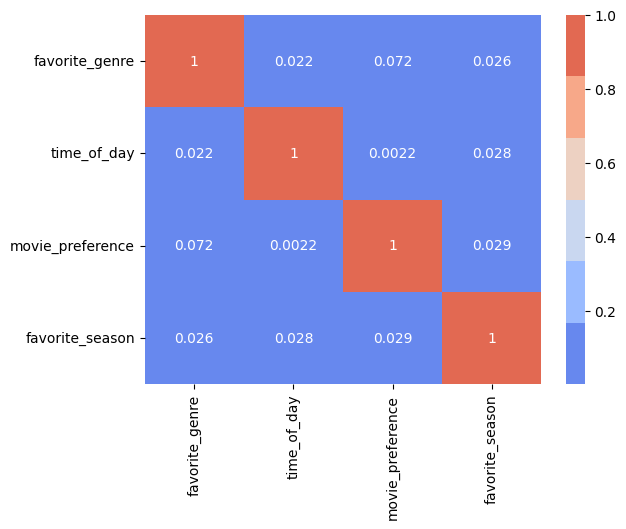

In [ ]:
# Calculate the correlation matrix
corr = data_norm[categorical_features].corr()

# Plot the heatmap 
sns.heatmap(corr,  xticklabels=corr.columns.values, yticklabels=corr.columns.values, cmap=sns.color_palette('coolwarm'), annot=True)


They are all independent so we chose to keep them all.

These are the selected features for the dimensionality reduction:

In [47]:

features = ['user_id','average_duration_per_day','ratio_weekend_weekday', 
            'zapping_percentage', 'average_movies_per_month','average_time_between_watches', 
            'content_diversity_index','favorite_genre',
        'time_of_day', 'movie_preference', 'favorite_season']

data_norm_reduced = data_norm[features]

Now of course we need to drop all the duplicates and keep one row for each user

In [48]:
data_norm_reduced = data_norm_reduced.drop_duplicates(subset='user_id', keep='first')
data_norm_reduced

,user_id,average_duration_per_day,ratio_weekend_weekday,zapping_percentage,average_movies_per_month,average_time_between_watches,content_diversity_index,favorite_genre,time_of_day,movie_preference,favorite_season
0,00004e2862,0.000000,0.558376,0.000000,0.000000,0.000000,0.090909,5,2,0,3
1,000052a0a0,0.000235,0.553299,0.451389,0.044959,0.006037,0.590909,0,2,1,2
25,000090e7c8,0.000000,0.558376,0.000000,0.000000,0.000000,0.090909,14,2,1,1
26,000118a755,0.000000,0.548223,0.000000,0.008174,0.000314,0.045455,11,2,1,2
29,000296842d,0.001685,0.548223,0.464286,0.024523,0.000625,0.136364,7,2,1,3
...,...,...,...,...,...,...,...,...,...,...,...
649986,fffd9bf758,0.000741,0.558376,0.000000,0.000000,0.000000,0.090909,5,2,1,2
649987,fffe7b777b,0.000156,0.568528,0.000000,0.000000,0.000000,0.090909,7,0,1,2
649988,fffeac83be,0.003540,0.517766,0.098485,0.018392,0.017173,0.363636,7,2,1,2
649999,ffff2c5f9e,0.000000,0.573604,0.000000,0.004087,0.000050,0.181818,0,0,1,2


### 2. Dimensionality reduction

Principal Component Analysis (PCA) is a statistical technique used for dimensionality reduction and feature extraction in data analysis. It is particularly useful in reducing the number of variables in a dataset while retaining as much of the original information as possible. Here are some advantages or pros of using PCA:

1. **Data Visualization:** PCA is often used for data visualization purposes. It allows you to project high-dimensional data onto a lower-dimensional space (usually 2 or 3 dimensions) while preserving the most important information. This facilitates the identification of patterns, clusters, or trends in the data.

2. **Collinearity Handling:** PCA can be useful when dealing with multicollinearity, a situation where independent variables in a dataset are highly correlated. The principal components are orthogonal, meaning they are uncorrelated, which can help mitigate the collinearity issue.


In [49]:
data_pca=data_norm_reduced.loc[:,data_norm_reduced.columns != 'user_id']

It's important for PCA to standardize the data

In [50]:
scaler = StandardScaler()
data_pca = scaler.fit_transform(data_pca)

In [51]:
# Applying PCA to the features
pca = PCA() 
pca_components = pca.fit_transform(data_pca)

Now we want to see how many components are necessary using the *explained_variance_ratio_* function

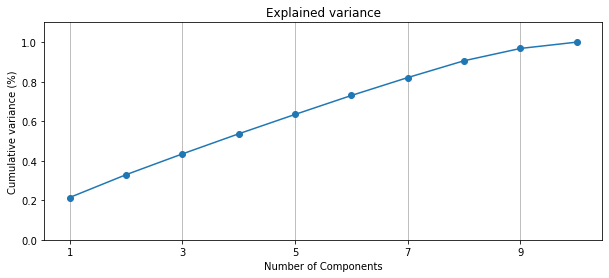

In [52]:
# Explained variance 
pca = PCA().fit(data_pca)
fig, ax = plt.subplots(figsize=(12,5))
xi = np.arange(1, 1+data_pca.shape[1], step=1)
yi = np.cumsum(pca.explained_variance_ratio_)
plt.plot(xi, yi, marker='o')


plt.ylim(0.0,1.1)
plt.xlabel('Number of Components')
plt.xticks(np.arange(1, 1+data_pca.shape[1], step=2))
plt.ylabel('Cumulative variance (%)')
plt.title('Explained variance')
ax.grid(axis='x')

A good number of features could be when the cumulative variance is at 80%

In [53]:
# Calculating the cumulative explained variance
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

# Determining the number of components 
n_components = np.argmax(cumulative_variance_ratio >= 0.80) + 1
n_components

7

Applying PCA with the chosen number of components (7, in this case)

In [54]:
pca = PCA(n_components=n_components)
data_reduced = pca.fit_transform(data_pca)

As we said earlier PCA is useful to visualize the data, so now we plot the first two principal components in a 2D graph and the first three principal components in the 3D model below.

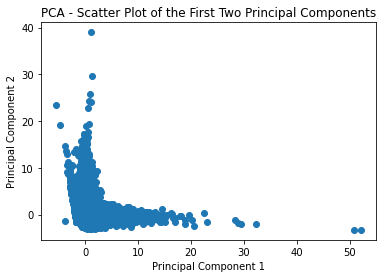

In [55]:
plt.scatter(data_reduced[:, 0], data_reduced[:, 1])
plt.title('PCA - Scatter Plot of the First Two Principal Components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

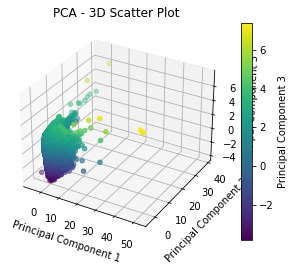

In [56]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(data_reduced[:, 0], data_reduced[:, 1],data_reduced[:, 2] , c=data_reduced[:, 2], cmap='viridis')

ax.set_title('PCA - 3D Scatter Plot')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')

# Adding a colorbar
cbar = fig.colorbar(scatter, ax=ax, label='Principal Component 3')

plt.show()


In [57]:
#converting the PCA reduced data to a pandas dataframe.
data_final=pd.DataFrame(data_reduced)

#We want the User ID to still be the primary key for our projected data 

data_final.index = data_norm_reduced['user_id']
data_final

,0,1,2,3,4,5,6
user_id,,,,,,,
00004e2862,-1.048322,-1.506168,0.586066,1.241243,0.544535,0.419952,-1.714800
000052a0a0,3.470310,-0.613362,0.541658,0.211986,1.006471,-0.542008,1.457044
000090e7c8,-0.584572,-0.110177,-1.440874,0.362781,-1.685428,-0.590317,-0.806439
000118a755,-0.259728,-0.420331,-1.390965,0.642282,-0.693939,-0.399078,-0.918880
000296842d,1.452601,-1.367514,-1.325479,0.747585,0.430428,0.123207,0.540403
...,...,...,...,...,...,...,...
fffd9bf758,-0.831037,-0.428220,-0.674920,0.516855,0.071369,-0.642214,-0.180091
fffe7b777b,-1.086489,0.022871,-1.081861,-1.200653,0.188887,0.787000,-0.391845
fffeac83be,2.026405,0.469810,-0.213639,0.805002,0.140555,-0.486430,-0.716628


## 2.3


### 1

**Outline of the code**

1. Initialize random centroids
2. Get labels for each data point (Map)
3. Create new centroids (Reduce)
4. Plot the centroids
5. Repeat 3-5 until the centroids stop changing


In [592]:

def assign_centroid(centroids,p):
    #computing the distances from all the centroids
    distances = [np.linalg.norm(p - centroid) for centroid in centroids]
    #choosing the closest
    closest_centroid = np.argmin(distances)
    return closest_centroid

def map_(data, centroids):
    cluster_assignments = []
    for point in data:
        #for each point in the dataset it will assigned the cluster 
        cluster_assignments.append((assign_centroid(centroids, point), point))
    return cluster_assignments

def reduce_(cluster_assignments, k):
    cluster_assignments = np.array(cluster_assignments, dtype=object) 
    # for each cluster take the mean of the points and set these as new centroids
    new_centroids = [np.mean(cluster_assignments[cluster_assignments[:, 0] == i][:, 1], axis=0) for i in range(k)]
    return new_centroids

def plot_clusters(data,centroids,cluster_assignments, k, i):
    # In order to visualize the clustering process we use PCA once again to make a 2-dimentional plot
    pca = PCA(n_components=2)
    data_2d = pca.fit_transform(data)
    centroids_2d = pca.transform(centroids)
    cluster_ids, clustered_data = zip(*cluster_assignments)
    
    # Plot the clustered data
    plt.scatter(data_2d[:, 0], data_2d[:, 1], c=cluster_ids, cmap='viridis', alpha=0.7)
    plt.scatter(centroids_2d[:, 0], centroids_2d[:, 1], s=100, c='red')
    plt.title(f'Iteration (i={i})')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()
    plt.show()
    
# K-means algorithm
def Kmeans_from_scratch_with_plot_mapreduce(data, k):
    
    # Step 1: Initialize centroids randomly
    centroids = data[np.random.choice(len(data), k, replace=False)]
    
    #we chose 100 as the max number of iterations as a stopping point
    for i in range(100):
        # Step 2: Get labels for each data point (Map)
        cluster_assignments = map_(data, centroids)
        
        # Step 3: Create new centroids (Reduce)
        new_centroids = reduce_(cluster_assignments, k)
        
        # Step 5: Repeat 3-5 until the centroids stop changing
        if np.all(np.array(new_centroids) == np.array(centroids)):
            # Step 4: Plot the centroids
            plot_clusters(data,centroids,cluster_assignments, k, i)
            break

        # Update centroids for the next iteration
        centroids = new_centroids

    return centroids

### 2


Find an optimal number of clusters.

#### Method 1: Elbow

The elbow method is the most widely used method for choosing the number of clusters. It runs clustering models for a range of cluster numbers and plots the within cluster sum of squares. The elbow on the plot shows the point where the diminishing returns for additional clusters happen.

In [593]:
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.metrics import silhouette_score

C:\Users\Gabriele\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\yellowbrick\utils\kneed.py:156: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\Gabriele\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\yellowbrick\cluster\elbow.py:374: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


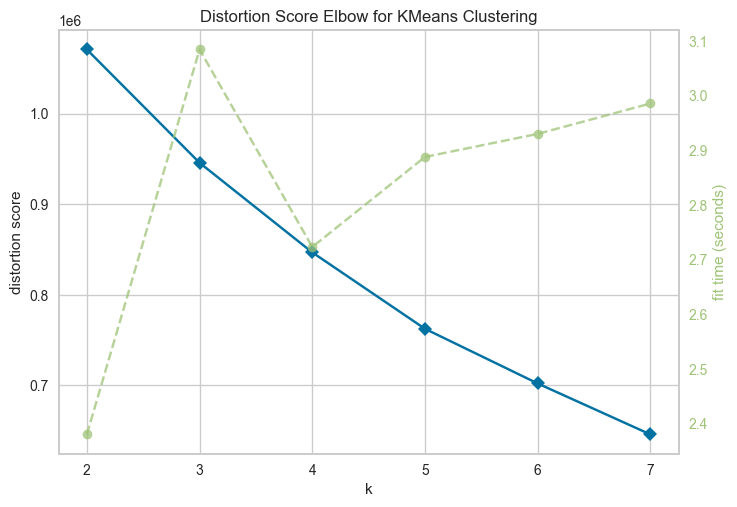

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [594]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,8))

visualizer.fit(data_reduced)
visualizer.show()

##### Method 2: Silhouette method

In [595]:
#We took a sample of 10,000 items from our dataset
data_sample = data_final.sample(10000)

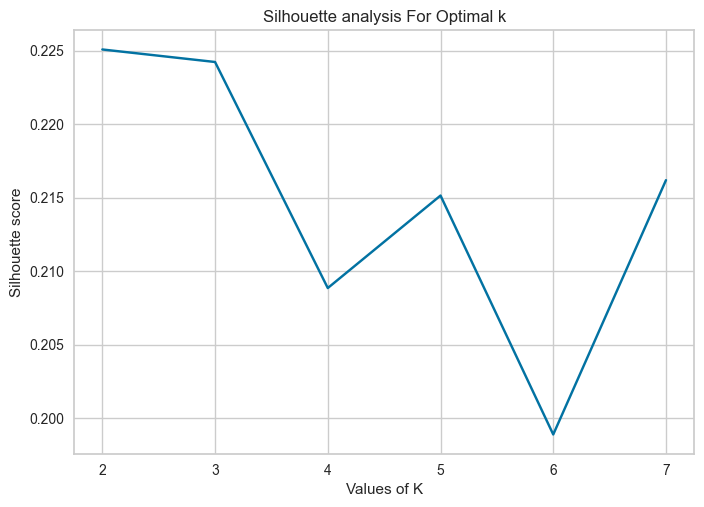

In [596]:
clusters = [2, 3, 4, 5, 6, 7]
silhouette_avg = []

for cluster in clusters:
    kmeans=KMeans(n_clusters=cluster, random_state=42).fit(data_sample)
    cluster_labels = kmeans.labels_
    silhouette_avg.append(silhouette_score(data_sample, cluster_labels))
    
plt.plot(clusters,silhouette_avg,'bx-')    
plt.xlabel('Values of K') 
plt.ylabel('Silhouette score') 
plt.title('Silhouette analysis For Optimal k')
plt.show()

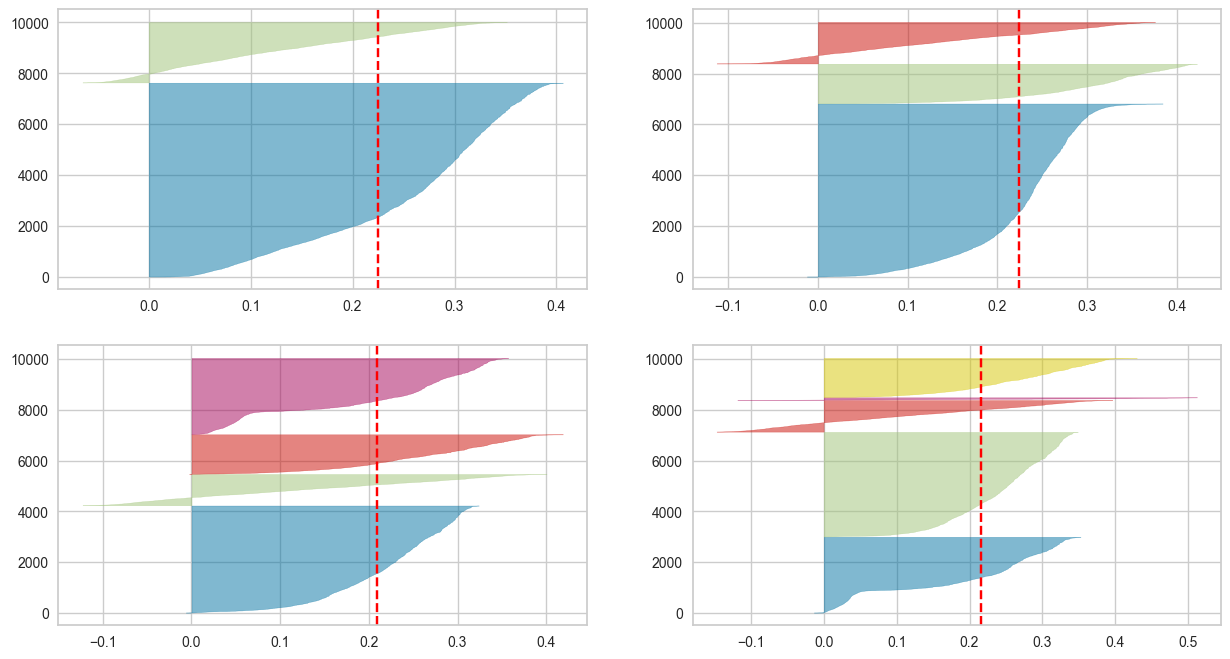

In [597]:
fig, ax = plt.subplots(2, 2, figsize=(15,8))
for i in [2, 3, 4, 5]:
    km = KMeans(n_clusters=i, random_state=42)
    q, mod = divmod(i, 2)
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(data_sample)
    cluster_labels = km.fit_predict(data_sample)
    silhouette_avg = silhouette_score(data_sample, cluster_labels)

#### Method 3: Hierarchical Graph

The y axis is the euclidean distance, so the longer the vertical line is, the larger distance between the clusters.


Text(0, 0.5, 'Euclidean Distance')

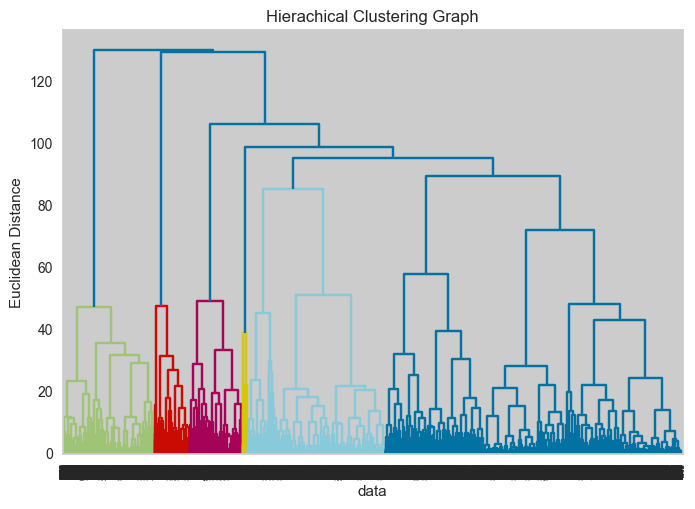

In [598]:
plt.figure()

# Fit the heirachical graph
heirachical_graph=hier.dendrogram(hier.linkage(data_sample, method='ward')) #method='ward' uses the Ward variance minimization algorithm

# Add titles and labels
plt.title('Hierachical Clustering Graph')
plt.xlabel('data')
plt.ylabel('Euclidean Distance')

- Unfortunately Method 1 (Elbow) didn't give us a visible elbow
- Method 2 (Silhouette) seems to suggest k=2 or 3 but there was no clear winner
- Method 3 (Hierarchical) has 5 blue lines suggesting k=6

Since all three methods didn't yield a significant result, we based our choice on the plot of the first principal components. The plot in question showed that there are not well defined clusters, so we implemented the clustering algorithms with the lowest number of clusters that can give meaningful results (**3**, in this case) so that we can avoid excessive partitioning of the data or, on the other side, too simplistic answers.

### 3. Run the algorithm on the data obtained from the dimensionality reduction.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


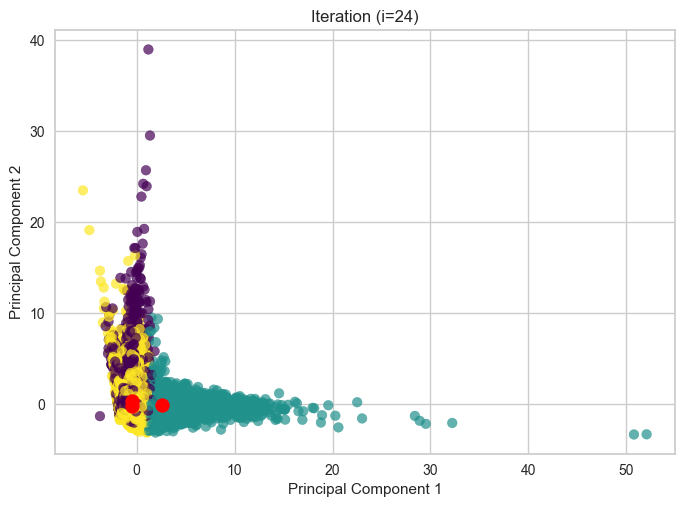

In [600]:
optimal_k=3
final_centroids = Kmeans_from_scratch_with_plot_mapreduce(data_reduced, optimal_k)

This is a plot is losing a lot of dimensions, so even though two final centroids seem overlapping they might be actually distant 

### 4. Implement K-means++ from scratch and explain the differences with the results you got earlier.

In [601]:
def kmeans_plusplus_init(data, k):
    # Choose the first centroid randomly from the data points
    centroids = [data[np.random.choice(data.shape[0])]]
    
    # Choose the remaining centroids using K-means++ method
    for _ in range(1, k):
        # Calculate distances from each data point to the nearest existing centroid
        distances = np.array([min(np.linalg.norm(point - np.array(centroid)) for centroid in centroids) for point in data])

        # Calculate probabilities for each data point based on squared distances
        probabilities = distances**2 / np.sum(distances**2)

        # Choose the next centroid randomly from the data points based on probabilities
        new_centroid = data[np.random.choice(data.shape[0], p=probabilities)]
        centroids.append(new_centroid)

    return np.array(centroids)

This implementation randomly selects the first centroid and then chooses the subsequent centroids with a probability proportional to the squared distance from the nearest existing centroid. This ensures that the initial centroids are well spread out in the data space.

K-means++ is typically used as the initialization step to provide better starting points for convergence. in fact other than the initial centroids the code is the same as before

In [602]:
# K-means++ algorithm
def Kmeans_pp_from_scratch_with_plot_mapreduce(data, k):
    # Step 1: Initialize centroids with the new method (++)
    centroids = kmeans_plusplus_init(data, k)

    for i in range(100):
        # Step 2: Get labels for each data point (Map)
        cluster_assignments = map_(data, centroids)
        
        # Step 3: Create new centroids (Reduce)
        new_centroids = reduce_(cluster_assignments, k)
                
        # Step 5: Repeat 3-5 until the centroids stop changing
        if np.all(np.array(new_centroids) == np.array(centroids)):
            # Step 4: Plot the centroids
            plot_clusters(data,centroids,cluster_assignments, k, i)
            break

        # Update centroids for the next iteration
        centroids = new_centroids

    return centroids

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


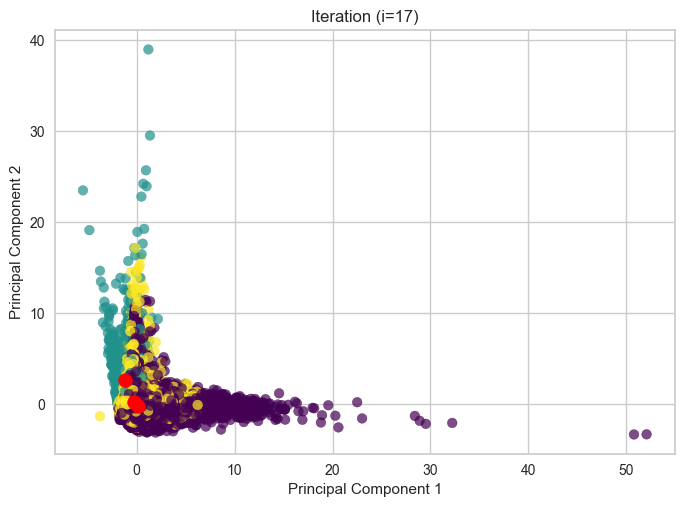

In [603]:
final_centroids = Kmeans_pp_from_scratch_with_plot_mapreduce(data_reduced, optimal_k)

 This method is supposed to reduce the number of iteration (faster convergence). This means that, over many runs, this last algorithm will always give a consistently low number of iterations, and the former will be more unstable depending on the first random centroids. The clusters don't seem to be more defined than before.

### 5. Ask ChatGPT to recommend other clustering algorithms and choose one. Explain your choice, then ask ChatGPT to implement it or use already implemented versions (e.g., the one provided in the scikit-learn library) and run it on your data. Explain the differences (if there are any) in the results. Which one is the best, in your opinion, and why?

Gaussian Mixture Model (GMM) is a probabilistic model that represents a mixture of multiple Gaussian distributions. It is often used for clustering and density estimation. These are some advantages or pros of using Gaussian Mixture Models:

1. **Flexibility in Modeling Complex Distributions:** GMMs are capable of modeling complex probability distributions by combining multiple Gaussian components. This flexibility allows GMMs to represent a wide range of data patterns and structures.

2. **Soft Assignment of Data Points:** Unlike hard clustering algorithms that assign each data point to a single cluster, GMMs provide a soft assignment by assigning probabilities to each data point belonging to each cluster. This soft assignment can be more realistic in situations where data points may belong to multiple clusters simultaneously.

3. **No Assumption of Equal Cluster Sizes or Variances:** Unlike K-means, which assumes equal cluster sizes and variances, GMMs do not impose such constraints. This makes GMMs more suitable for situations where the clusters have varying sizes and shapes.

4. **Density Estimation:** GMMs can be used for density estimation, allowing for the estimation of the underlying probability distribution of the data. This is useful in applications such as anomaly detection.

The last two points highlight the specific reasons for choosing the Gaussian Mixture Model (GMM) in our analysis. Based on the results from the previous clustering, it appears that we are dealing with the subdivision of one large cluster. By opting for the GMM method, we can take into account the density of the points, considering not only the distance from a centroid but also the probability distribution. This is crucial, as GMMs allow for clusters of different sizes and shapes, accommodating the inherent variability in the data rather than assuming equal cluster sizes and variances, as done in traditional methods like K-means. The ability of GMMs to perform density estimation further enhances our capability to identify and handle anomalies effectively in the dataset.

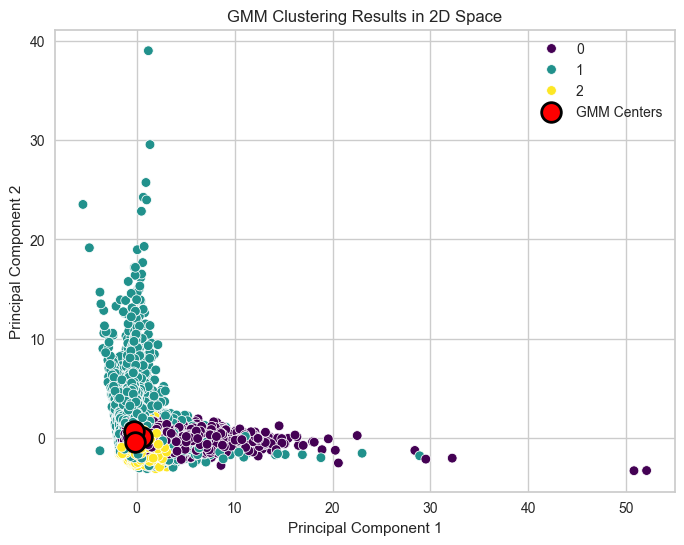

In [604]:
from sklearn.mixture import GaussianMixture

# Create a Gaussian Mixture Model
gmm = GaussianMixture(n_components=optimal_k)

# Fit the GMM to the reduced data
gmm.fit(data_reduced)

# Predict the cluster labels for each data point
cluster_labels = gmm.predict(data_reduced)

# You can also obtain the probabilities of each sample belonging to each cluster
# This can be useful for assessing the uncertainty of the clustering
probs = gmm.predict_proba(data_reduced)

# Now, cluster_labels contains the cluster assignments for each data point
# probs contains the probability scores for each data point in each cluster
plt.figure(figsize=(8, 6))
sns.scatterplot(x=data_reduced[:, 0], y=data_reduced[:, 1], hue=cluster_labels, palette='viridis', legend='full')

# Plot the GMM cluster centers
means = gmm.means_
plt.scatter(means[:, 0], means[:, 1], marker='o', s=200, c='red', edgecolors='black', linewidths=2, label='GMM Centers')

plt.title('GMM Clustering Results in 2D Space')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

It is evident that the data exhibits a more complex structure than a simple partition into equally sized and shaped clusters. In particular, the analysis reveals the presence of a more dense cluster (referred to as Cluster 2) located in the middle of the plotted points. This observation aligns with the advantages of using GMMs, as highlighted before.

## 2.4 Analysing your results! 

You are often encouraged to explain the main characteristics that your clusters have. The latter is called the Characterizing Clusters step. Thus, follow the next steps to do it:

Let's use our Kmeans++ algorithm

In [628]:
cluster_assignments = map_(data_reduced, final_centroids)
cluster_assignments = np.array(cluster_assignments, dtype=object)
cluster_assignments[:, 0]

array([0, 0, 0, ..., 0, 2, 0], dtype=object)

In [606]:
#Create an empty column to add to the dataframe
data_norm_reduced['Cluster'] = data_norm_reduced.apply(lambda _: '', axis=1)
data_norm_reduced.head()

,user_id,average_duration_per_day,ratio_weekend_weekday,zapping_percentage,average_movies_per_month,average_time_between_watches,content_diversity_index,favorite_genre,time_of_day,movie_preference,favorite_season,Cluster
0,00004e2862,0.000000,0.558376,0.000000,0.000000,0.000000,0.090909,5,2,0,3,
1,000052a0a0,0.000235,0.553299,0.451389,0.044959,0.006037,0.590909,0,2,1,2,
25,000090e7c8,0.000000,0.558376,0.000000,0.000000,0.000000,0.090909,14,2,1,1,
26,000118a755,0.000000,0.548223,0.000000,0.008174,0.000314,0.045455,11,2,1,2,
29,000296842d,0.001685,0.548223,0.464286,0.024523,0.000625,0.136364,7,2,1,3,


In [629]:
#Fill the column with the corresponding cluster for each customer
data_norm_reduced['Cluster'] = cluster_assignments[:, 0]+1

In [630]:
data_norm_reduced['Cluster'].head()

0     1
1     1
25    1
26    1
29    1
Name: Cluster, dtype: object

In [ ]:
data_norm_reduced.columns #the features to choose from

In [632]:
data_norm_reduced.columns

Index(['user_id', 'average_duration_per_day', 'ratio_weekend_weekday',
       'zapping_percentage', 'average_movies_per_month',
       'average_time_between_watches', 'content_diversity_index',
       'favorite_genre', 'time_of_day', 'movie_preference', 'favorite_season',
       'Cluster'],
      dtype='object')

#### 1. Select 2-3 variables you think are relevant to identify the cluster of the customer. 

In [633]:
#Select variables we think are important to identify a cluster
data1 = pd.DataFrame(data_norm_reduced, columns=['ratio_weekend_weekday', 'average_duration_per_day', 'zapping_percentage', 'Cluster'])
data1.head()

,ratio_weekend_weekday,average_duration_per_day,zapping_percentage,Cluster
0,0.558376,0.000000,0.000000,1
1,0.553299,0.000235,0.451389,1
25,0.558376,0.000000,0.000000,1
26,0.548223,0.000000,0.000000,1
29,0.548223,0.001685,0.464286,1


#### 2. Most of your selected variables will be numerical (continuous or discrete), then categorise them into four categories.

In [634]:
#Add a column with the respective category for each numerical variable 
data1['Categories_ratio_weekend_weekday'] = pd.cut(data1['ratio_weekend_weekday'], [0, .25, .5, .75, 1.], labels=[1,2,3,4], include_lowest=True) 
data1['Categories_average_duration_per_day'] = pd.cut(data1['average_duration_per_day'], [0, .25, .5, .75, 1.], labels=[1,2,3,4],include_lowest=True)
data1['Categories_zapping_percentage'] = pd.cut(data1['zapping_percentage'], [0, .25, .5, .75, 1.], labels=[1,2,3,4],include_lowest=True)

In [635]:
data1['Categories_ratio_weekend_weekday'].head()

0     3
1     3
25    3
26    3
29    3
Name: Categories_ratio_weekend_weekday, dtype: category
Categories (4, int64): [1 < 2 < 3 < 4]

In [636]:
data1['Categories_average_duration_per_day'].head()

0     1
1     1
25    1
26    1
29    1
Name: Categories_average_duration_per_day, dtype: category
Categories (4, int64): [1 < 2 < 3 < 4]

In [637]:
data1['Categories_zapping_percentage'].head()

0     1
1     2
25    1
26    1
29    2
Name: Categories_zapping_percentage, dtype: category
Categories (4, int64): [1 < 2 < 3 < 4]

In [638]:
data1.head()

,ratio_weekend_weekday,average_duration_per_day,zapping_percentage,Cluster,Categories_ratio_weekend_weekday,Categories_average_duration_per_day,Categories_zapping_percentage
0,0.558376,0.000000,0.000000,1,3,1,1
1,0.553299,0.000235,0.451389,1,3,1,2
25,0.558376,0.000000,0.000000,1,3,1,1
26,0.548223,0.000000,0.000000,1,3,1,1
29,0.548223,0.001685,0.464286,1,3,1,2


#### 3. With the selected variables, perform pivot tables. On the horizontal axis, you will have the clusters, and on the vertical axis, you will have the categories of each variable. Notice that you have to do one pivot table per variable.

In [639]:
data1.pivot_table('ratio_weekend_weekday', ['Cluster'], ['Categories_ratio_weekend_weekday'], aggfunc={'Categories_ratio_weekend_weekday':'count'})

Categories_ratio_weekend_weekday,1,2,3,4
Cluster,,,,
1,15,1902,93999,1
2,0,1,2410,0
3,0,405,55654,1


In [640]:
data1.pivot_table('average_duration_per_day', ['Cluster'], ['Categories_average_duration_per_day'],aggfunc={'Categories_average_duration_per_day':'count'})

Categories_average_duration_per_day,1,2,3,4
Cluster,,,,
1,95917,0,0,0
2,2350,55,4,2
3,56060,0,0,0


In [641]:
data1.pivot_table('zapping_percentage', ['Cluster'], ['Categories_zapping_percentage'], aggfunc={'Categories_zapping_percentage':'count'})

Categories_zapping_percentage,1,2,3,4
Cluster,,,,
1,75870,12515,7036,496
2,2175,102,133,1
3,46874,5555,3425,206


#### 4. Calculate the percentage by column for each pivot table. The sum of each row (cluster) must be 100.

In [642]:
table=data1.pivot_table('ratio_weekend_weekday', ['Cluster'], ['Categories_ratio_weekend_weekday'], aggfunc={'Categories_ratio_weekend_weekday':'count'})
# Calculate percentages
table_percentage = table.div(table.sum(axis=1), axis=0) * 100
table_percentage

Categories_ratio_weekend_weekday,1,2,3,4
Cluster,,,,
1,0.015639,1.982964,98.000354,0.001043
2,0.000000,0.041477,99.958523,0.000000
3,0.000000,0.722440,99.275776,0.001784


In [643]:
table=data1.pivot_table('average_duration_per_day', ['Cluster'], ['Categories_average_duration_per_day'],aggfunc={'Categories_average_duration_per_day':'count'})
# Calculate percentages
table_percentage = table.div(table.sum(axis=1), axis=0) * 100
table_percentage

Categories_average_duration_per_day,1,2,3,4
Cluster,,,,
1,100.000000,0.000000,0.000000,0.000000
2,97.469929,2.281211,0.165906,0.082953
3,100.000000,0.000000,0.000000,0.000000


In [644]:
table=data1.pivot_table('zapping_percentage', ['Cluster'], ['Categories_zapping_percentage'], aggfunc={'Categories_zapping_percentage':'count'})
# Calculate percentages
table_percentage = table.div(table.sum(axis=1), axis=0) * 100
table_percentage

Categories_zapping_percentage,1,2,3,4
Cluster,,,,
1,79.099638,13.047739,7.335509,0.517114
2,90.211530,4.230610,5.516383,0.041477
3,83.613985,9.909026,6.109526,0.367463


#### 5. Interpret the results for each pivot table.

Each value in the pivot table represents the percentage of each category of a variable in the cluster of the corresponding row. For example, in the last pivot table, 83.61% is the percentage of values of the variable 'zapping_percentage' which are in the first category and in the third cluster. As we can easily calculate the sum of each row is 100 which means that every element of each cluster belongs to a category.

It seems like you've provided a detailed analysis of three pivot tables related to different features in a clustering algorithm. While your analysis is informative, I can help you refine and structure it for clarity. Here's a revised version:

**1. ratio_weekend_weekday Pivot Table:**
   - Predominance in the third category is observed across all clusters.
   - Notable distinctions:
      - Clusters 2 and 3 lack values in the first category.
      - Cluster 1 is distinct in having values in the first category.

**2. average_duration_per_day Pivot Table:**
   - Concentration of values in the first category.
   - Cluster differences:
      - Only cluster 2 contains values in the remaining three categories.

**3. zapping_percentage Pivot Table:**
   - Less evident imbalance compared to the other features.
   - Similar percentages for category 1 across all clusters, indicating minimal cluster-based variations.
   
**Overall Importance in Clustering Algorithm:**
   - Zapping_percentage seems less crucial due to consistent percentages across clusters.
   - Ratio_weekend_weekday and average_duration_per_day exhibit more pronounced cluster-specific patterns.
   - While the first two features show significant cluster differences, neither appears to be a sole determinant in the clustering decision.

**Conclusion:**
   - Ratio_weekend_weekday and average_duration_per_day contribute more substantially to clustering decisions, with discernible cluster-specific variations.
   - Zapping_percentage, while less impactful, still provides information, albeit with less variation between clusters.

#### 6. Use any known metrics to estimate clustering algorithm performance (how good are the clusters you found?).

The silhouette Coefficient is the most popular evaluation metrics for clustering algorithms. The formula is the following one: $$s = \frac{b-a}{max(b-a)}$$ <br> where **a** is the mean distance between a sample and all other points in the same cluster while **b** is the mean distance between a sample and all other points in the next nearest cluster. <br> The score is bounded between $[-1, 1]$ where -1 means incorrect clustering and 1 means highly dense and wellseparated clusters. 0 means overlapping clusters. 

In [645]:
from sklearn.metrics import silhouette_score

In [649]:
silhouette_score(data_reduced, cluster_assignments[:, 0], metric='euclidean',sample_size=100000)

0.15600455514076547

To evaluate the clustering we obtained, we used the silhouette score but given the dimensions of the data matrix we had to take just a sample (with size = 100000) to make it run in reasonable time. The result is encouraging, it is bigger than zero which means our clustering goes in the right direction but there might be a little overlapping.

# 4. Command Line Question (CLQ)

**What is the most-watched Netflix title?**

In [ ]:
awk -F, '{print $4}' dataset.csv | sort | uniq -c | sort -nr | head -n 1

**Provide the ID of the user that has spent the most time on Netflix**

In [ ]:
awk -F, '{duration[$NF] += $3} END {for (id in duration) print duration[id], id}' dataset.csv | sort -nr | head -n 1

**Report the average time between subsequent clicks on Netflix.com**

In [ ]:
awk -F, 'NR>1 {print $2}' dataset.csv | 
while read -r line; do 
    date -j -f "%Y-%m-%d %T" "$line" +%s
done | 
awk 'NR>1 {print $1-prev} {prev=$1}' | 
awk '{sum+=$1; count+=1} END {if (count > 0) print sum/count}'


# 5. Algorithmic Question (AQ)

He was given an initial personal score of **S** when he enrolled, which changes every time he takes an exam: now comes the crazy part. He soon discovered that every of the **N** exams he has to take is assigned a mark **p**. Once he has chosen an exam, his score becomes equal to the mark **p**, and at the same time, the scoring system changes:

-  If he takes an "easy" exam (the score of the exam being less than his score), every other exam's mark is increased by the quantity **S-p**.
-  If he takes a "hard" exam (the score of the exam is greater than his score), every other exam's mark is decreased by the quantity **p-S**.


In this chaotic university where the only real exam seems to be choosing the best way to take exams, you are the poor student advisor who is facing a long queue of confused people who need some help. Federico is next in line, and he comes up in turn with an inescapable question: he wants to know which is the highest score possible he could get.

**a) Fortunately, you have a computer app designed by a brilliant student. Federico wants you to show him the code which this app is based on because he wants to do paid counseling for other desperate students: in a recursive fashion, the helped helps the helpable.**

In [ ]:
def solution1(S,grades):
    results=[]
    #define the function that returns the list with all the possible outcomes
    def function(grades,S,r):
        for i in range(len(grades)):
            #build the list with the new grades after taking one exam
            changed_grades=[x+(S-grades[i]) for x in grades[:i]+grades[i+1:]]
            if len(changed_grades)==1:
                r.append(changed_grades[0])
            else:
                function(changed_grades, grades[i],r)
        return r
    #find the highest possible final grade
    return(max(function(grades,S,[])))


**b) Federico is getting angry because he claims that your code is slow! Show him formally with a big-O notation that he is as crazy as this university!**


The time complexity of the provided code is O(N!) where N is the length of the list of initial grades. This is because the function `function(grades, S, r)` is recursively called for every element in the `grades` list, creating a new list for each call. 

The function essentially generates all permutations of the grades list. To be more specific, the function explores all possible outcomes of improving grades, which means it considers each possible sequence of exams a student could take. This is similar to generating all permutations of a list, which is known to have a time complexity of O(N!)
Here is a step-by-step breakdown of the time complexity:

1. The function is called once for each grade in the grades list, which gives us N recursive calls.
2. For each recursive call, the function creates a new list `changed_grades` that excludes one grade and adds (S - grade[i]) to each remaining grade. This operation has a time complexity of O(N) as it needs to iterate over the list.
3. Each recursive call then generates its own set of recursive calls, again one for each grade in the `changed_grades` list. This results in N! (N factorial) total function calls, since for each of the N grades there are (N-1) recursive calls, for each of those there are (N-2) calls, and so on down to 1.
4. The function then finds the maximum value in the results list, which requires iterating over the list once and has a time complexity of O(N).

Therefore, the overall time complexity is O(N!) due to the factorial number of recursive calls, each of which performs an operation that takes O(N) time. This is a worst-case scenario as it assumes that the recursive calls are not terminated early and all possible sequences of exams are explored.

**c) If, unfortunately, Federico is right in the grip of madness, he will threaten you to optimize the code through a different approach. You should end this theater of the absurd by any means! (And again, formally prove that you improved time complexity)**


To find an optimized code let's analyze the problem further:

1. Let's notice that it doesn't matter if the exam chosen next is "easier" or not because adding $S-p$ is equivalent to subtracting $p-S$. From now on we will only add $S-p$ when choosing a new exam

2. Let's see some examples of the process to get better understanding of what is happening.
    - initialize $S$ and $p=[p_1,p_2]$ and $p_1 \leq p_2$
        - randomly select $p_2$ so now: $S^1=p_2$ and $p^1=[p_1+S-p_2]=S^{final}$
        - randomly select $p_1$ so now: $S^1=p_1$ and $p^1=[p_2+S-p_1]=S^{final}$

        so the two possible final grades are $p_2+S-p_1$ or $p_1+S-p_2$ but since we are looking for the maximum we will select $p_2+S-p_1$ ($p_1 \leq p_2$)
    - initialize $S$ and $p=[p_1,p_2,p_3]$ and $p_1 \leq p_2 \leq p_3$
        - randomly select $p_3$ so now: $S^1=p_3$ and $p^1=[p_1+S-p_3, p_2+S-p_3]$
            - randomly select $p_2+S-p_3$ so now: $S^2=p_2+S-p_3$ and $p^2=[p_1+S-p_3+S^1-(p_2+S-p_3)]=[p_1+S-p_3+p_3-(p_2+S-p_3)]=[p_1+p_3-p_2]$
            - randomly select $p_1+S-p_3$ so now: $S^2=p_1+S-p_3$ and $p^2=[p_2+S-p_3+S^1-(p_1+S-p_3)]=[p_2+S-p_3+p_3-(p_1+S-p_3)]=[p_2+p_3-p_1]$

        choosing different paths will bring the same kind of result, where two grades are summed and one is subtracted and S doesn't come up in the final grade. So the maximum grade will of course be $p_2+p_3-p_1$
3. We noticed there is a difference between the results where the number of grades is even or odd. Let's propose a solution and let's try to demonstrate it.
$$S^{final, max} = \sum^n_{j=\frac{n-1}{2}+1}{p_j} - \sum^{\frac{n-1}{2}}_{j=1}{p_j} \quad {when\ n\ is\ odd}$$
$$S^{final, max} = S + \sum^n_{j=\frac{n}{2}+1}{p_j} - \sum^{\frac{n}{2}}_{j=1}{p_j} \quad {when\ n\ is\ even}$$

Let's show that if $n$ is odd then the final result does not depend from $S$. the algorithm has to make $n−1$ choices for the exams (the last is forced). Every 2 rounds of choices $S$ is added and subtracted (see previous example). $n-1$ is even so there is no $S$ in the final grade. Consequently, when $n$ is even, $S$ is added one last time.

Now we prove our optimized algorithm using strong induction on the length $n$ of the vector of exams.
- $n=1$ obvious
- $n=2,3$ shown above

By inductive hypothesis we have that the algorithm is right $\forall k<n$ and the same parity (we are actually doing two different problems).

Let's show when n is odd. In this case we can assume $S=0$ and $[p_1,p_2, ... , p_n]$ is in ascending order, We randomly choose $p_i$ as our first exam and adjust our list as $[p_1-p_i, ... , p_n-p_i]$ that now has $n-1$ grades ($n-1$ is even so we can't use the inductive hypotesis). Now we randomly choose $p_j-p_i$ as the next exam and adjust our list as $[p_1-p_j+p_i, ... , p_n-p_j+p_i]$ (calculations were shown before). Now we can use the hypotesis on the new list and say the maximum grade we can achieve is:
$$S^{final, max} = \sum^n_{k=\frac{n-1}{2}+1, k\not=i,j}{p_k-p_j+p_i} - \sum^{\frac{n-1}{2}}_{k=1, k\not=i,j}{p_k-p_j+p_i} $$ 
In order to make the values of the grades in the list the greatest possible (so that the final grade is as highest as possible), we should consider $i=n$ and $j=1$. In this case the grade is the greatest possible and, rewriting the last formula, is in the form:

\begin{align*}
S^{final, max} &= \sum^n_{k=\frac{n-1}{2}+1, k\not=n}{p_k-p_1+p_n} - \sum^{\frac{n-1}{2}}_{k=1, k\not=1}{p_k-p_1+p_n} \\
&=(\sum^n_{k=\frac{n-1}{2}+1, k\not=n}{p_k} - \sum^{\frac{n-1}{2}}_{k=1, k\not=1}{p_k}) + (-p_1+p_n) \\
&=(\sum^n_{k=\frac{n-1}{2}+1}{p_k} - \sum^{\frac{n-1}{2}}_{k=1}{p_k}) + (-p_1+p_n) - p_n + p_1 \\
&=\sum^n_{k=\frac{n-1}{2}+1}{p_k} - \sum^{\frac{n-1}{2}}_{k=1}{p_k} \\

\end{align*}
which concludes our proof. The reasoning is similar for even values of $n$.

The code is simple:

In [1]:
def solution2(S, grades):
  n = len(grades)

  # Sort the grades in ascending order
  grades = sorted(grades)

  # Lower half of the grades summed:
  lower = sum([grades[i] for i in range(0, n // 2)])

  # Upper half of the grades summed:
  upper = sum([grades[i] for i in range(n // 2, n)]) 

  # following what we said earlier
  if n % 2 == 0:  
    return(S + upper - lower)
    
  if n % 2 == 1:
    return(upper - lower)

Let's analyze the time complexity of this code:

- Sorting the grades: The sorting operation has a time complexity of O(n log n), where n is the number of grades.

- Summing the lower half of grades: The sum operation involves iterating over the first half of the sorted list, which takes O(n/2) time in the worst case.

- Summing the upper half of grades: Similarly, the sum operation for the second half of the sorted list takes O(n/2) time in the worst case.

Therefore, the overall time complexity of the code is dominated by the sorting operation, and it is O(n log n).


**d) Ask chatGPT for a third (optimized) implementation and analyze again its time complexity. Be careful (and crafty) in defining the prompt, and challenge the machine in this coding question!**

This is the code that ChatGPT provided us

In [ ]:
def solution_chatgpt(grades, current_score, memo):
    # Base case: If no exams left, return the current score
    if not grades:
        return current_score

    # Sort and convert to tuple for consistent memoization key
    grades_key = tuple(sorted(grades))

    # Check if this state has been computed before
    if (grades_key, current_score) in memo:
        return memo[(grades_key, current_score)]

    max_score = 0
    for i, grade in enumerate(grades):
        new_score = grade
        updated_grades = grades[:i] + grades[i+1:]

        if grade < current_score:
            updated_grades = [g + current_score - grade for g in updated_grades]
        else:
            updated_grades = [g - grade + current_score for g in updated_grades]

        max_score = max(max_score, solution_chatgpt(updated_grades, new_score, memo))

    memo[(grades_key, current_score)] = max_score
    return max_score

The time complexity of this recursive solution depends on the number of recursive calls and the work done within each call.

- Recursive Calls: In the worst case, the function explores all possible combinations of grades, making a recursive call for each combination. The number of recursive calls is exponential in the number of grades, but memoization helps avoid redundant calculations.

- Work within Each Call: For each recursive call, the function performs a constant amount of work, including sorting the grades, creating a tuple for memoization, and iterating through the grades. The dominant factor is the sorting operation, which has a time complexity of O(n log n), where n is the number of grades.

Considering both factors, the overall time complexity is O(n!), where n is the number of grades. Memoization significantly reduces the actual computation time by avoiding redundant calculations.
So it is somewhat better than solution1 but not solution2 which seems to be optimal.

**Solutions used on the examples in the homework** 

In [ ]:
S=8
grades=[5,7,1]

print('First Solution: ',solution1(S, grades))
print('Second Solution: ',solution2(S, grades))
print('ChatGPT Solution: ',solution_chatgpt(grades,S,{}))

In [ ]:
S=25
grades=[18, 24, 21, 32, 27]

print('First Solution: ',solution1(S, grades))
print('Second Solution: ',solution2(S, grades))
print('ChatGPT Solution: ',solution_chatgpt(grades,S,{}))

In [ ]:
S=30
grades=[13, 27, 41, 59, 28, 33, 39, 19, 52, 48, 55, 79]


print('Second Solution: ',solution2(S, grades))
print('ChatGPT Solution: ',solution_chatgpt(grades,S,{}))

We are not showing the results for the first solution because it will take too much time